In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="ON/OFF code"></form>''')

In [21]:
# Algumas funções práticas

def anotaGrafico(ax):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

            # Number of points between bar and label. Change to your liking.
        space = 1
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label + '\n',                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)

# Análise Exploratória COVID-19

***

   O intuito deste Notebook é de explorar a base de dados públicos do novo coronavírus disponível no painel do [DataSUS](https://covid.saude.gov.br/). Informações sobre o que é o COVID-19 e outras dúvidas relacionadas podem ser encontradas na página [principal do repositório](https://github.com/leocneves/COVID-19) ou no próprio site do [Ministério da Saúde](https://coronavirus.saude.gov.br/sobre-a-doenca#o-que-e-covid).
Vamos visualizar algumas informações relevantes de maneira gráfica quanto ao registro de novos casos e óbitos por região e pelo Brasil, bem como informações de faixa etária e algumas outras comparações relevantes.

***

Conteúdo:

1. [Análise Inicial dos Dados](#1.-Análise-Inicial-dos-Dados)
    - Dados ausentes
    - Tipos de Dados
    
    
2. [Volumes dos Dados](#2.-Volumes-dos-Dados)
    - Visualizações de casos novos/óbitos por região/Brasil
    - Visualizações da evolução

***

### 1. Análise Inicial dos Dados

In [3]:
df = pd.read_excel('../datasets/covid_brasil.xlsx')

- Quantidade de valores ausentes e tipos das colunas:

In [4]:
pd.DataFrame(columns=['Coluna', 'Tipo', 'Qtd. Nulos'], data=np.array([df.columns.values, 
                                                             df.dtypes.values, 
                                                             df.isna().sum().values]).T)

,Coluna,Tipo,Qtd. Nulos
0,regiao,object,0
1,estado,object,80
2,municipio,object,2259
3,coduf,int64,0
4,codmun,float64,1787
5,codRegiaoSaude,float64,2259
6,nomeRegiaoSaude,object,2259
7,data,object,0
8,semanaEpi,int64,0
9,populacaoTCU2019,float64,472


In [5]:
# Transformações Necessárias

df = df[df.estado.notna()] # Retirando estados faltantes (número de deleções aceitável com base na tabela acima)

df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d') # Transformação da coluna de data de tipo string -> tipod data


### 2. Volumes dos Dados

- Acumulado de casos por região, óbitos e letalidade

In [6]:
pd.pivot_table(df, values=['regiao', 'casosAcumulado', 'obitosAcumulado'], 
               columns=['estado'], aggfunc=[np.max]).xs('amax', axis=1, 
                                                        drop_level=True).T.reset_index().groupby('regiao').agg({'casosAcumulado':np.sum, 'obitosAcumulado':np.sum}).reset_index()

,regiao,casosAcumulado,obitosAcumulado
0,Centro-Oeste,6617,162
1,Nordeste,72076,4223
2,Norte,40473,2762
3,Sudeste,88759,7345
4,Sul,10298,325


,regiao,Total de Casos,Total de Obitos,% Região para Brasil,% Obitos
0,Centro-Oeste,6617,162,3.03,2.45
1,Nordeste,72076,4223,33.03,5.86
2,Norte,40473,2762,18.55,6.82
3,Sudeste,88759,7345,40.67,8.28
4,Sul,10298,325,4.72,3.16


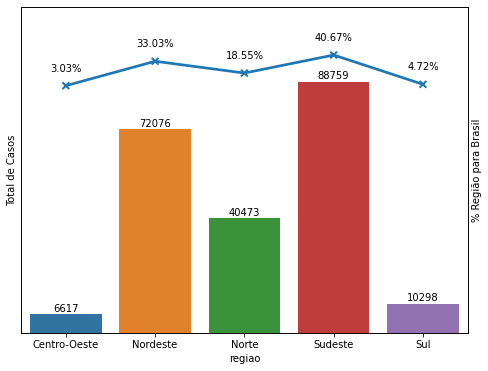

In [7]:
df_vol = pd.pivot_table(df, values=['regiao', 'casosAcumulado', 'obitosAcumulado'], 
               columns=['estado'], aggfunc=[np.max]).xs('amax', axis=1, 
                                                        drop_level=True).T.reset_index().groupby('regiao').agg({'casosAcumulado':np.sum, 'obitosAcumulado':np.sum}).reset_index()

df_vol.rename(columns={'casosAcumulado':'Total de Casos', 'obitosAcumulado':'Total de Obitos'}, inplace = True)

df_vol['% Região para Brasil'] = round((df_vol['Total de Casos'] / df_vol['Total de Casos'].sum()) * 100, 2) # % da região 
df_vol['% Obitos'] = round((df_vol['Total de Obitos'] / df_vol['Total de Casos']) * 100, 2) # Letalidade
display(df_vol)

fig, ax = plt.subplots(figsize=(8,6)) 
# Criando os plots
sn.barplot(x='regiao', y='Total de Casos', data=df_vol, ax=ax)
ax2 = plt.twinx()
sn.pointplot(x='regiao', y='% Região para Brasil', data=df_vol, ax=ax2, markers='x')

# Setando configurações
ax.set(ylim=(0, df_vol['Total de Casos'].max()*1.3), yticks=[])
ax2.set(ylim=(-300, 100), yticks=[])

# Anotando
for rect, i in zip(ax.patches, df_vol['% Região para Brasil'].values):
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 1
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:.0f}".format(y_value)

    # Create annotation
    ax.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.
        
    ax2.annotate(
        str(i) + '%\n',                      # Use `label` as label
        (x_value, i),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

plt.show()

- Acumulado de casos novos de COVID-19 por Semana Epidemiológica de notificação Brasil

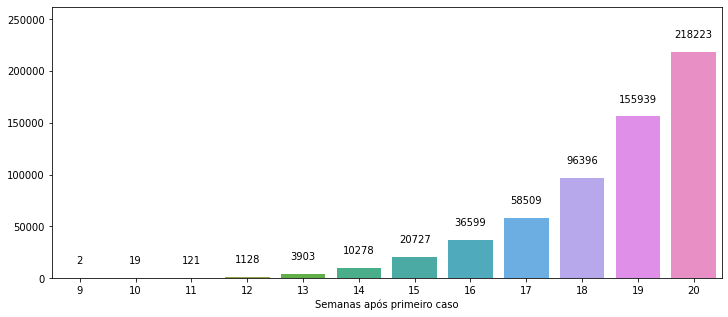

In [25]:
df_group_data = df.groupby(['regiao', 'estado', 'semanaEpi'])['casosAcumulado'].max().reset_index().groupby(['regiao', 'semanaEpi']).sum().reset_index().groupby(['semanaEpi']).sum().reset_index()

# df_group_data['casosNovosAcumulado'] = df_group_data['casosNovos'].cumsum()

fig, ax = plt.subplots(figsize=(12,5))
g = sn.barplot(x='semanaEpi', y='casosAcumulado', data=df_group_data) # , hue='regiao', ax=ax

ax.set(xlabel='Semanas após primeiro caso', ylabel='')

# # calculate linear regression function
# X = list(range(len(df_group_data['data'])))

# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=np.array(X), y=df_group_data['casosNovosAcumulado'].apply(np.log1p))

# # X.extend([15,16])

# g.plot(X, np.exp(intercept + slope * np.array(X)), 'r')

g.set(ylim=(0, df_group_data['casosAcumulado'].max()*1.2))

anotaGrafico(ax)

plt.show()

- Acumulado de casos novos de COVID-19 por Semana Epidemiológica de notificação Brasil por região

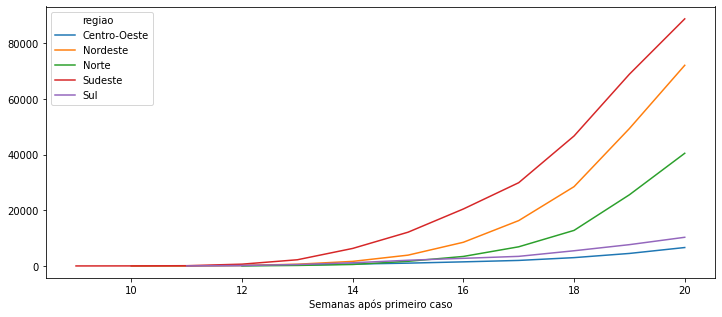

In [27]:
df_group_data = df.groupby(['regiao', 'estado', 'semanaEpi'])['casosAcumulado'].max().reset_index().groupby(['regiao', 'semanaEpi']).sum().reset_index()

# df_group_data['casosNovosAcumulado'] = df_group_data['casosNovos'].cumsum()

fig, ax = plt.subplots(figsize=(12,5))
g = sn.lineplot(x='semanaEpi', y='casosAcumulado', data=df_group_data, hue='regiao', ax=ax) 
g.set(xlabel='Semanas após primeiro caso', ylabel='')

anotaGrafico(ax)

# g.set(xlim=(-1, 15))
plt.show()